In [138]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint

In [139]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

In [140]:
patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [141]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [142]:
p1 = os.listdir("v1.2.0/eval")
print(p1)
print(os.path.isdir(p1[0]))
print(os.path.isfile(p1[1]))
pathString = ("/"+str(p1[0]))
print(pathString)
patientDict = {}
fileNames = []
maxFileSize = 0 
maxFileName = ""
for root,dirs,files in os.walk("v1.2.0"):
    #print ("root: ",root)
    #print("\tdirs: ",dirs)
    #print("\t\t",str(files))
        
    if len(files)>0:
        for file in files:
            fileNames.append(str(root)+"/"+str(file))
            if os.path.getsize((str(root)+"/"+file)) > maxFileSize:
                maxFileSize = os.path.getsize((str(root)+"/"+file))
                maxFileName = (str(root)+"/"+file)
            else:
                continue
            
            
        #print ("\t\tFile: "+files[3])
        
print (maxFileName," : ",maxFileSize)
print (os.path.splitext(maxFileName))
print (os.path.split(maxFileName))
print (os.path.splitext(os.path.split(maxFileName)[1]))
print (fileName(maxFileName))
print (fileExt(maxFileName))

['03_tcp_ar_a', '02_tcp_le', '.DS_Store', '01_tcp_ar']
False
False
/03_tcp_ar_a
v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17/00001278_s002_t001.edf  :  67899648
('v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17/00001278_s002_t001', '.edf')
('v1.2.0/eval/01_tcp_ar/00001278/s002_2003_11_17', '00001278_s002_t001.edf')
('00001278_s002_t001', '.edf')
00001278_s002_t001
.edf


In [154]:
def addFile(filepath):
    splitFile = filepath.split('/')
    if len(splitFile)<6:
        print("File path too short")
    else:
        patientId = splitFile[3]
        currentFile = splitFile[5] #changed from 5 to 4
        currentSessionNumber = splitFile[4].split('_')[0]
        currentFileSplit = currentFile.split('_')
        currentFileExt = str(fileExt(currentFile))
        sessionNumber = currentFileSplit[0] #Changed from 1 to 0
        sessionId = str(patientId)+str(currentSessionNumber)
        print("\tFile Path: ",filepath)
        print("\t\tCurrentFile: ",currentFile)
        print("\t\tCurrentFileExt: ",currentFileExt)
        print("\t\tSessionId: ",sessionId)
        dbSession = sessions.find_one({"sessionId":sessionId})
        
        if dbSession == None:
            print("Found a new session")
            sessions.insert_one({"sessionId":sessionId,"patientId":patientId})
        else:
            print("Found this session\n")  
        if currentFileExt == ".txt":
            try:
                with open(str(files),'r') as reportFile:
                    rText = reportFile.readlines()  
                try:
                    sessions.update_one({"sessionId":sessionId},
                                       {"$set":{"reportText":rText}})
                except:
                    print("Could not add report text")     
            except UnicodeDecodeError:
                sessions.update_one({"sessionId":sessionId},
                                       {"$set":{"reportText":"Unopenable"}})
        elif currentFileExt  == ".edf":
            try:
                updateEdf = dbSession['edfList']
                updateEdf.append(filepath)
                sessions.update_one({"sessionId":sessionId},{"$set":{"edfList":updateEdf}})    
            except:
                #print ("No edf") 
                sessions.update_one({"sessionId":sessionId},{"$set":{"edfList":[filepath]}})
        elif currentFileExt == ".lbl":
            try:
                updateLbl = dbSession['lblList']
                updateLbl.append(filepath)
                #print("\n\nUPDATING LABL LIST-------------")
                #print(updateLbl)
                sessions.update_one({"sessionId":sessionId},{"$set":{"lblList":updateLbl}})
            except:
                sessions.update_one({"sessionId":sessionId},{"$set":{"lblList":[filepath]}})
                
        elif currentFileExt == ".tse":
            try:
                updateTse = dbSession['tseList']
                updateTse.append(filepath)
                updateTseData = dbSession['tseData']
                with open(str(files),'r') as reportFile:
                    tseData = reportFile.readlines()  
                #tseData = tseData.split(' ')
                try:
                    tseEntry = {'startTime':tseData[0],'endTime':tseData[1],
                               'eventLabel':tseData[2],'probability':tseData[3]}
                except:
                    tseEntry='Error'
                updateTseData.append(tseEntry)
                
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseList":updateTse}})
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseData":updateTseData}})
            except:
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseList":[filepath]}})
                with open(str(files),'r') as reportFile:
                    tseData = reportFile.readlines()  
                try:
                    tseEntry = {'startTime':tseData[0],'endTime':tseData[1],
                               'eventLabel':tseData[2],'probability':tseData[3]}
                except:
                    tseEntry='Error'
                sessions.update_one({"sessionId":sessionId},{"$set":{"tseData":[tseEntry]}})

In [155]:
#print(fileNames[0:30])
testDb.patients.delete_many({})
testDb.sessions.delete_many({})
testDb.reports.delete_many({})

for files in fileNames:
    addFile(files)
    

File path too short
File path too short
File path too short
File path too short
	File Path:  v1.2.0/eval/03_tcp_ar_a/00005943/s002_2009_06_28/00005943_s002.txt
		CurrentFile:  00005943_s002.txt
		CurrentFileExt:  .txt
		SessionId:  00005943s002
Found a new session
	File Path:  v1.2.0/eval/03_tcp_ar_a/00005943/s002_2009_06_28/00005943_s002_t002.lbl_bi
		CurrentFile:  00005943_s002_t002.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00005943s002
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00005943/s002_2009_06_28/00005943_s002_t001.tse_bi
		CurrentFile:  00005943_s002_t001.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00005943s002
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00005943/s002_2009_06_28/00005943_s002_t000.lbl_bi
		CurrentFile:  00005943_s002_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00005943s002
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00005943/s002_2009_06_28/00005943_s002_t003.tse_bi
		CurrentFile:  00005943_s002_t003.

		CurrentFileExt:  .edf
		SessionId:  00004087s003
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00004087/s003_2007_07_24/00004087_s003_t001.tse_bi
		CurrentFile:  00004087_s003_t001.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00004087s003
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00004087/s003_2007_07_24/00004087_s003_t002.lbl_bi
		CurrentFile:  00004087_s003_t002.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00004087s003
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00004087/s003_2007_07_24/00004087_s003_t002.edf
		CurrentFile:  00004087_s003_t002.edf
		CurrentFileExt:  .edf
		SessionId:  00004087s003
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00004087/s003_2007_07_24/00004087_s003_t003.tse_bi
		CurrentFile:  00004087_s003_t003.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00004087s003
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00004087/s003_2007_07_24/00004087_s003_t003.edf
		CurrentFile:  00004087_s003_t003.ed

	File Path:  v1.2.0/eval/03_tcp_ar_a/00002297/s003_2007_10_23/00002297_s003_t001.lbl_bi
		CurrentFile:  00002297_s003_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00002297s003
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00002297/s004_2007_10_23/00002297_s004_t001.lbl_bi
		CurrentFile:  00002297_s004_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00002297s004
Found a new session
	File Path:  v1.2.0/eval/03_tcp_ar_a/00002297/s004_2007_10_23/00002297_s004_t000.tse_bi
		CurrentFile:  00002297_s004_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00002297s004
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00002297/s004_2007_10_23/00002297_s004_t001.edf
		CurrentFile:  00002297_s004_t001.edf
		CurrentFileExt:  .edf
		SessionId:  00002297s004
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00002297/s004_2007_10_23/00002297_s004_t000.edf
		CurrentFile:  00002297_s004_t000.edf
		CurrentFileExt:  .edf
		SessionId:  00002297s004
Found this session

		CurrentFile:  00006546_s012_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00006546s012
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00006546/s012_2011_02_17/00006546_s012_t003.tse
		CurrentFile:  00006546_s012_t003.tse
		CurrentFileExt:  .tse
		SessionId:  00006546s012
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00006546/s012_2011_02_17/00006546_s012_t003.lbl
		CurrentFile:  00006546_s012_t003.lbl
		CurrentFileExt:  .lbl
		SessionId:  00006546s012
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00006546/s012_2011_02_17/00006546_s012_t001.lbl
		CurrentFile:  00006546_s012_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00006546s012
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00006546/s012_2011_02_17/00006546_s012_t001.tse
		CurrentFile:  00006546_s012_t001.tse
		CurrentFileExt:  .tse
		SessionId:  00006546s012
Found this session

	File Path:  v1.2.0/eval/03_tcp_ar_a/00006546/s012_2011_02_17/00006546_s012_t000.tse
		CurrentFile:  000

		CurrentFile:  00004087_s001_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00004087s001
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00004087/s001_2007_06_26/00004087_s001.txt
		CurrentFile:  00004087_s001.txt
		CurrentFileExt:  .txt
		SessionId:  00004087s001
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00004087/s001_2007_06_26/00004087_s001_t000.tse_bi
		CurrentFile:  00004087_s001_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00004087s001
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00004087/s002_2007_07_23/00004087_s002_t000.lbl_bi
		CurrentFile:  00004087_s002_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00004087s002
Found a new session
	File Path:  v1.2.0/eval/02_tcp_le/00004087/s002_2007_07_23/00004087_s002_t000.tse_bi
		CurrentFile:  00004087_s002_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00004087s002
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00004087/s002_2007_07_23/00004087_s002.txt
		CurrentFile:  0


	File Path:  v1.2.0/eval/02_tcp_le/00002297/s002_2007_10_22/00002297_s002_t000.lbl_bi
		CurrentFile:  00002297_s002_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00002297s002
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00002297/s002_2007_10_22/00002297_s002_t000.edf
		CurrentFile:  00002297_s002_t000.edf
		CurrentFileExt:  .edf
		SessionId:  00002297s002
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00002297/s002_2007_10_22/00002297_s002.txt
		CurrentFile:  00002297_s002.txt
		CurrentFileExt:  .txt
		SessionId:  00002297s002
Found this session

	File Path:  v1.2.0/eval/02_tcp_le/00004151/s002_2007_09_28/00004151_s002_t001.lbl_bi
		CurrentFile:  00004151_s002_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00004151s002
Found a new session
	File Path:  v1.2.0/eval/02_tcp_le/00004151/s002_2007_09_28/00004151_s002_t002.tse_bi
		CurrentFile:  00004151_s002_t002.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00004151s002
Found this session

	File Path:  v1.2

		CurrentFileExt:  .lbl_bi
		SessionId:  00008453s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s004_2012_01_26/00008453_s004_t002.lbl_bi
		CurrentFile:  00008453_s004_t002.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00008453s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s004_2012_01_26/00008453_s004_t001.tse_bi
		CurrentFile:  00008453_s004_t001.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008453s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s004_2012_01_26/00008453_s004_t008.lbl
		CurrentFile:  00008453_s004_t008.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008453s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s004_2012_01_26/00008453_s004_t008.tse
		CurrentFile:  00008453_s004_t008.tse
		CurrentFileExt:  .tse
		SessionId:  00008453s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s004_2012_01_26/00008453_s004_t000.lbl_bi
		CurrentFile:  00008453_s004_t000.lbl_bi
		Curren

		CurrentFileExt:  .lbl_bi
		SessionId:  00008453s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s008_2012_03_07/00008453_s008_t009.lbl_bi
		CurrentFile:  00008453_s008_t009.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00008453s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s008_2012_03_07/00008453_s008_t006.tse_bi
		CurrentFile:  00008453_s008_t006.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008453s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s008_2012_03_07/00008453_s008_t001.edf
		CurrentFile:  00008453_s008_t001.edf
		CurrentFileExt:  .edf
		SessionId:  00008453s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s008_2012_03_07/00008453_s008_t010.tse_bi
		CurrentFile:  00008453_s008_t010.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008453s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008453/s008_2012_03_07/00008453_s008_t011.tse
		CurrentFile:  00008453_s008_t011.tse
		Cur

		CurrentFile:  00008174_s002_t003.tse
		CurrentFileExt:  .tse
		SessionId:  00008174s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008174/s002_2011_09_23/00008174_s002_t002.tse_bi
		CurrentFile:  00008174_s002_t002.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008174s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008174/s002_2011_09_23/00008174_s002_t001.tse
		CurrentFile:  00008174_s002_t001.tse
		CurrentFileExt:  .tse
		SessionId:  00008174s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008174/s002_2011_09_23/00008174_s002_t001.lbl
		CurrentFile:  00008174_s002_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008174s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008174/s002_2011_09_23/00008174_s002_t000.lbl
		CurrentFile:  00008174_s002_t000.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008174s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008174/s002_2011_09_23/00008174_s002_t000.tse
		CurrentFile:  00008174_s

		CurrentFile:  00008544_s004_t002.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008544s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s004_2012_01_04/00008544_s004_t003.lbl_bi
		CurrentFile:  00008544_s004_t003.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00008544s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s011_2012_01_08/00008544_s011_t006.edf
		CurrentFile:  00008544_s011_t006.edf
		CurrentFileExt:  .edf
		SessionId:  00008544s011
Found a new session
	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s011_2012_01_08/00008544_s011_t007.edf
		CurrentFile:  00008544_s011_t007.edf
		CurrentFileExt:  .edf
		SessionId:  00008544s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s011_2012_01_08/00008544_s011_t011.edf
		CurrentFile:  00008544_s011_t011.edf
		CurrentFileExt:  .edf
		SessionId:  00008544s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s011_2012_01_08/00008544_s011_t005.edf
		CurrentFile:  00008544_s

		CurrentFileExt:  .tse
		SessionId:  00008544s009
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s009_2012_01_06/00008544_s009_t002.tse
		CurrentFile:  00008544_s009_t002.tse
		CurrentFileExt:  .tse
		SessionId:  00008544s009
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s009_2012_01_06/00008544_s009_t002.lbl
		CurrentFile:  00008544_s009_t002.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008544s009
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s009_2012_01_06/00008544_s009_t000.lbl
		CurrentFile:  00008544_s009_t000.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008544s009
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s009_2012_01_06/00008544_s009_t000.tse
		CurrentFile:  00008544_s009_t000.tse
		CurrentFileExt:  .tse
		SessionId:  00008544s009
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008544/s009_2012_01_06/00008544_s009_t006.lbl_bi
		CurrentFile:  00008544_s009_t006.lbl_bi
		CurrentFileExt:  .lbl_bi
		

Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s003_2012_03_12/00002289_s003_t005.edf
		CurrentFile:  00002289_s003_t005.edf
		CurrentFileExt:  .edf
		SessionId:  00002289s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s003_2012_03_12/00002289_s003_t011.edf
		CurrentFile:  00002289_s003_t011.edf
		CurrentFileExt:  .edf
		SessionId:  00002289s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s003_2012_03_12/00002289_s003_t010.edf
		CurrentFile:  00002289_s003_t010.edf
		CurrentFileExt:  .edf
		SessionId:  00002289s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s003_2012_03_12/00002289_s003_t004.edf
		CurrentFile:  00002289_s003_t004.edf
		CurrentFileExt:  .edf
		SessionId:  00002289s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s003_2012_03_12/00002289_s003_t000.edf
		CurrentFile:  00002289_s003_t000.edf
		CurrentFileExt:  .edf
		SessionId:  00002289s003
Found this session

	File Path:  v1

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s005_2012_03_14/00002289_s005_t005.lbl_bi
		CurrentFile:  00002289_s005_t005.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00002289s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s005_2012_03_14/00002289_s005_t001.lbl
		CurrentFile:  00002289_s005_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00002289s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s005_2012_03_14/00002289_s005_t001.tse
		CurrentFile:  00002289_s005_t001.tse
		CurrentFileExt:  .tse
		SessionId:  00002289s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s005_2012_03_14/00002289_s005_t005.tse
		CurrentFile:  00002289_s005_t005.tse
		CurrentFileExt:  .tse
		SessionId:  00002289s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00002289/s005_2012_03_14/00002289_s005_t005.lbl
		CurrentFile:  00002289_s005_t005.lbl
		CurrentFileExt:  .lbl
		SessionId:  00002289s005
Found this session

	File Path:  v1.2.0/eval/0

		SessionId:  00009866s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009866/s002_2013_07_24/00009866_s002.txt
		CurrentFile:  00009866_s002.txt
		CurrentFileExt:  .txt
		SessionId:  00009866s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009866/s002_2013_07_24/00009866_s002_t000.edf
		CurrentFile:  00009866_s002_t000.edf
		CurrentFileExt:  .edf
		SessionId:  00009866s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009866/s002_2013_07_24/00009866_s002_t001.edf
		CurrentFile:  00009866_s002_t001.edf
		CurrentFileExt:  .edf
		SessionId:  00009866s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009866/s002_2013_07_24/00009866_s002_t001.tse_bi
		CurrentFile:  00009866_s002_t001.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009866s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009866/s002_2013_07_24/00009866_s002_t002.lbl_bi
		CurrentFile:  00009866_s002_t002.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009866s002


		CurrentFile:  00010106_s002_t006.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00010106s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010106/s002_2013_02_08/00010106_s002_t005.lbl_bi
		CurrentFile:  00010106_s002_t005.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00010106s002
Found this session

File path too short
	File Path:  v1.2.0/eval/01_tcp_ar/00001027/s004_2004_01_30/00001027_s004_t003.lbl_bi
		CurrentFile:  00001027_s004_t003.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00001027s004
Found a new session
	File Path:  v1.2.0/eval/01_tcp_ar/00001027/s004_2004_01_30/00001027_s004_t000.tse_bi
		CurrentFile:  00001027_s004_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00001027s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00001027/s004_2004_01_30/00001027_s004_t001.lbl_bi
		CurrentFile:  00001027_s004_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00001027s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00001027/s004_2004_01

		SessionId:  00007633s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00007633/s003_2013_07_09/00007633_s003_t009.tse_bi
		CurrentFile:  00007633_s003_t009.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00007633s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00007633/s003_2013_07_09/00007633_s003_t011.lbl
		CurrentFile:  00007633_s003_t011.lbl
		CurrentFileExt:  .lbl
		SessionId:  00007633s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00007633/s003_2013_07_09/00007633_s003_t005.lbl
		CurrentFile:  00007633_s003_t005.lbl
		CurrentFileExt:  .lbl
		SessionId:  00007633s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00007633/s003_2013_07_09/00007633_s003_t008.lbl_bi
		CurrentFile:  00007633_s003_t008.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00007633s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00007633/s003_2013_07_09/00007633_s003_t001.lbl
		CurrentFile:  00007633_s003_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  000

	File Path:  v1.2.0/eval/01_tcp_ar/00004671/s011_2013_07_08/00004671_s011_t001.lbl
		CurrentFile:  00004671_s011_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00004671s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00004671/s011_2013_07_08/00004671_s011_t001.tse
		CurrentFile:  00004671_s011_t001.tse
		CurrentFileExt:  .tse
		SessionId:  00004671s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00004671/s011_2013_07_08/00004671_s011_t000.tse
		CurrentFile:  00004671_s011_t000.tse
		CurrentFileExt:  .tse
		SessionId:  00004671s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00004671/s011_2013_07_08/00004671_s011_t000.lbl
		CurrentFile:  00004671_s011_t000.lbl
		CurrentFileExt:  .lbl
		SessionId:  00004671s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00004671/s011_2013_07_08/00004671_s011_t001.lbl_bi
		CurrentFile:  00004671_s011_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00004671s011
Found this session

	File Path:  v1.2.0/eval/0

		CurrentFileExt:  .lbl
		SessionId:  00008889s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s003_2012_03_20/00008889_s003_t010.tse
		CurrentFile:  00008889_s003_t010.tse
		CurrentFileExt:  .tse
		SessionId:  00008889s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s003_2012_03_20/00008889_s003_t004.tse
		CurrentFile:  00008889_s003_t004.tse
		CurrentFileExt:  .tse
		SessionId:  00008889s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s003_2012_03_20/00008889_s003.txt
		CurrentFile:  00008889_s003.txt
		CurrentFileExt:  .txt
		SessionId:  00008889s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s003_2012_03_20/00008889_s003_t009.tse
		CurrentFile:  00008889_s003_t009.tse
		CurrentFileExt:  .tse
		SessionId:  00008889s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s003_2012_03_20/00008889_s003_t009.lbl
		CurrentFile:  00008889_s003_t009.lbl
		CurrentFileExt:  .lbl
		SessionId:  0000888

		CurrentFile:  00008889_s004_t002.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008889s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s004_2012_03_21/00008889_s004_t013.lbl_bi
		CurrentFile:  00008889_s004_t013.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00008889s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s004_2012_03_21/00008889_s004_t001.lbl_bi
		CurrentFile:  00008889_s004_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00008889s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s004_2012_03_21/00008889_s004_t000.tse_bi
		CurrentFile:  00008889_s004_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008889s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s004_2012_03_21/00008889_s004_t012.tse_bi
		CurrentFile:  00008889_s004_t012.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008889s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008889/s004_2012_03_21/00008889_s004_t0

		SessionId:  00009570s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009570/s002_2012_11_05/00009570_s002_t008.lbl
		CurrentFile:  00009570_s002_t008.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009570s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009570/s002_2012_11_05/00009570_s002_t008.tse
		CurrentFile:  00009570_s002_t008.tse
		CurrentFileExt:  .tse
		SessionId:  00009570s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009570/s002_2012_11_05/00009570_s002_t011.tse_bi
		CurrentFile:  00009570_s002_t011.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009570s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009570/s002_2012_11_05/00009570_s002_t000.lbl_bi
		CurrentFile:  00009570_s002_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009570s002
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009570/s002_2012_11_05/00009570_s002_t009.tse
		CurrentFile:  00009570_s002_t009.tse
		CurrentFileExt:  .tse
		SessionId:  000

		SessionId:  00008460s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008460/s006_2012_06_22/00008460_s006_t001.tse_bi
		CurrentFile:  00008460_s006_t001.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008460s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008460/s006_2012_06_22/00008460_s006_t001.tse
		CurrentFile:  00008460_s006_t001.tse
		CurrentFileExt:  .tse
		SessionId:  00008460s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008460/s006_2012_06_22/00008460_s006_t001.lbl
		CurrentFile:  00008460_s006_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008460s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008460/s006_2012_06_22/00008460_s006_t000.lbl
		CurrentFile:  00008460_s006_t000.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008460s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008460/s006_2012_06_22/00008460_s006_t000.tse
		CurrentFile:  00008460_s006_t000.tse
		CurrentFileExt:  .tse
		SessionId:  00008460s006

		CurrentFileExt:  .tse
		SessionId:  00009578s031
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s031_2013_08_24/00009578_s031_t015.tse
		CurrentFile:  00009578_s031_t015.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s031
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s031_2013_08_24/00009578_s031_t001.tse
		CurrentFile:  00009578_s031_t001.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s031
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s031_2013_08_24/00009578_s031_t001.lbl
		CurrentFile:  00009578_s031_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009578s031
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s031_2013_08_24/00009578_s031_t015.lbl
		CurrentFile:  00009578_s031_t015.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009578s031
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s031_2013_08_24/00009578_s031_t015.tse_bi
		CurrentFile:  00009578_s031_t015.tse_bi
		CurrentFileExt:  .tse_bi
		

		SessionId:  00009578s012
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s012_2013_08_14/00009578_s012_t003.tse_bi
		CurrentFile:  00009578_s012_t003.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s012
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s012_2013_08_14/00009578_s012_t009.lbl
		CurrentFile:  00009578_s012_t009.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009578s012
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s012_2013_08_14/00009578_s012_t009.tse
		CurrentFile:  00009578_s012_t009.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s012
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s012_2013_08_14/00009578_s012_t007.tse_bi
		CurrentFile:  00009578_s012_t007.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s012
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s012_2013_08_14/00009578_s012_t004.lbl_bi
		CurrentFile:  00009578_s012_t004.lbl_bi
		CurrentFileExt:  .lbl_bi
		Sessio

		SessionId:  00009578s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s004_2013_03_01/00009578_s004_t002.tse_bi
		CurrentFile:  00009578_s004_t002.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s004_2013_03_01/00009578_s004_t002.tse
		CurrentFile:  00009578_s004_t002.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s004_2013_03_01/00009578_s004_t001.lbl_bi
		CurrentFile:  00009578_s004_t001.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s004_2013_03_01/00009578_s004_t000.tse_bi
		CurrentFile:  00009578_s004_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s004_2013_03_01/00009578_s004_t007.lbl
		CurrentFile:  00009578_s004_t007.lbl
		CurrentFileExt:  .lbl
		Sessio

		CurrentFile:  00009578_s008_t004.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s008_2013_03_03/00009578_s008.txt
		CurrentFile:  00009578_s008.txt
		CurrentFileExt:  .txt
		SessionId:  00009578s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s008_2013_03_03/00009578_s008_t008.edf
		CurrentFile:  00009578_s008_t008.edf
		CurrentFileExt:  .edf
		SessionId:  00009578s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s008_2013_03_03/00009578_s008_t009.edf
		CurrentFile:  00009578_s008_t009.edf
		CurrentFileExt:  .edf
		SessionId:  00009578s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s008_2013_03_03/00009578_s008_t005.tse_bi
		CurrentFile:  00009578_s008_t005.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s008_2013_03_03/00009578_s008_t009.tse_bi
		CurrentFile:  00009578_s0

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s017_2013_08_16/00009578_s017_t002.edf
		CurrentFile:  00009578_s017_t002.edf
		CurrentFileExt:  .edf
		SessionId:  00009578s017
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s017_2013_08_16/00009578_s017_t003.edf
		CurrentFile:  00009578_s017_t003.edf
		CurrentFileExt:  .edf
		SessionId:  00009578s017
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s017_2013_08_16/00009578_s017_t004.lbl_bi
		CurrentFile:  00009578_s017_t004.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s017
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s029_2013_08_23/00009578_s029_t003.lbl_bi
		CurrentFile:  00009578_s029_t003.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s029
Found a new session
	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s029_2013_08_23/00009578_s029_t000.tse_bi
		CurrentFile:  00009578_s029_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s029
Found this session

	File Pa

		SessionId:  00009578s034
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s034_2013_08_27/00009578_s034_t008.tse
		CurrentFile:  00009578_s034_t008.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s034
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s034_2013_08_27/00009578_s034_t006.lbl_bi
		CurrentFile:  00009578_s034_t006.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s034
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s034_2013_08_27/00009578_s034_t005.tse_bi
		CurrentFile:  00009578_s034_t005.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s034
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s034_2013_08_27/00009578_s034_t009.tse_bi
		CurrentFile:  00009578_s034_t009.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s034
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s034_2013_08_27/00009578_s034_t008.lbl_bi
		CurrentFile:  00009578_s034_t008.lbl_bi
		CurrentFileExt:  .lbl_bi

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s011_2013_08_13/00009578_s011_t003.lbl_bi
		CurrentFile:  00009578_s011_t003.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s011_2013_08_13/00009578_s011_t000.tse_bi
		CurrentFile:  00009578_s011_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s011_2013_08_13/00009578_s011_t006.lbl_bi
		CurrentFile:  00009578_s011_t006.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009578s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s011_2013_08_13/00009578_s011_t001.edf
		CurrentFile:  00009578_s011_t001.edf
		CurrentFileExt:  .edf
		SessionId:  00009578s011
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s011_2013_08_13/00009578_s011_t000.edf
		CurrentFile:  00009578_s011_t000.edf
		CurrentFileExt:  .edf
		SessionId:  00009578s011
Found this session

	File Pa

		SessionId:  00009578s027
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s027_2013_08_21/00009578_s027_t004.tse
		CurrentFile:  00009578_s027_t004.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s027
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s027_2013_08_21/00009578_s027_t010.tse
		CurrentFile:  00009578_s027_t010.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s027
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s027_2013_08_21/00009578_s027_t006.tse
		CurrentFile:  00009578_s027_t006.tse
		CurrentFileExt:  .tse
		SessionId:  00009578s027
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s027_2013_08_21/00009578_s027_t006.lbl
		CurrentFile:  00009578_s027_t006.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009578s027
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009578/s027_2013_08_21/00009578_s027_t003.tse_bi
		CurrentFile:  00009578_s027_t003.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009578s027

Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010062/s007_2013_03_28/00010062_s007_t001.lbl
		CurrentFile:  00010062_s007_t001.lbl
		CurrentFileExt:  .lbl
		SessionId:  00010062s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010062/s007_2013_03_28/00010062_s007_t002.tse
		CurrentFile:  00010062_s007_t002.tse
		CurrentFileExt:  .tse
		SessionId:  00010062s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010062/s007_2013_03_28/00010062_s007_t002.lbl
		CurrentFile:  00010062_s007_t002.lbl
		CurrentFileExt:  .lbl
		SessionId:  00010062s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010062/s002_2013_03_11/00010062_s002_t000.tse_bi
		CurrentFile:  00010062_s002_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00010062s002
Found a new session
	File Path:  v1.2.0/eval/01_tcp_ar/00010062/s002_2013_03_11/00010062_s002.txt
		CurrentFile:  00010062_s002.txt
		CurrentFileExt:  .txt
		SessionId:  00010062s002
Found this session

	File Path:  v1.

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s005_2013_07_21/00009839_s005_t009.tse_bi
		CurrentFile:  00009839_s005_t009.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009839s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s005_2013_07_21/00009839_s005_t017.tse_bi
		CurrentFile:  00009839_s005_t017.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009839s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s005_2013_07_21/00009839_s005_t006.lbl_bi
		CurrentFile:  00009839_s005_t006.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009839s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s005_2013_07_21/00009839_s005_t018.lbl_bi
		CurrentFile:  00009839_s005_t018.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009839s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s005_2013_07_21/00009839_s005_t021.tse_bi
		CurrentFile:  00009839_s005_t021.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009839s005
Found this

		CurrentFile:  00009839_s008_t003.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009839s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s008_2013_07_23/00009839_s008_t000.lbl_bi
		CurrentFile:  00009839_s008_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009839s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s008_2013_07_23/00009839_s008_t001.tse_bi
		CurrentFile:  00009839_s008_t001.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009839s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s008_2013_07_23/00009839_s008_t002.lbl_bi
		CurrentFile:  00009839_s008_t002.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009839s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s008_2013_07_23/00009839_s008_t006.lbl_bi
		CurrentFile:  00009839_s008_t006.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00009839s008
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s008_2013_07_23/00009839_s008_t0

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s007_2013_07_22/00009839_s007_t007.lbl
		CurrentFile:  00009839_s007_t007.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009839s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s007_2013_07_22/00009839_s007_t006.lbl
		CurrentFile:  00009839_s007_t006.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009839s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s007_2013_07_22/00009839_s007_t012.lbl
		CurrentFile:  00009839_s007_t012.lbl
		CurrentFileExt:  .lbl
		SessionId:  00009839s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s007_2013_07_22/00009839_s007_t012.tse
		CurrentFile:  00009839_s007_t012.tse
		CurrentFileExt:  .tse
		SessionId:  00009839s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009839/s007_2013_07_22/00009839_s007_t006.tse
		CurrentFile:  00009839_s007_t006.tse
		CurrentFileExt:  .tse
		SessionId:  00009839s007
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/

		CurrentFileExt:  .tse_bi
		SessionId:  00009697s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009697/s003_2013_05_15/00009697_s003_t004.tse_bi
		CurrentFile:  00009697_s003_t004.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00009697s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009697/s003_2013_05_15/00009697_s003_t004.edf
		CurrentFile:  00009697_s003_t004.edf
		CurrentFileExt:  .edf
		SessionId:  00009697s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009697/s003_2013_05_15/00009697_s003_t005.edf
		CurrentFile:  00009697_s003_t005.edf
		CurrentFileExt:  .edf
		SessionId:  00009697s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009697/s003_2013_05_15/00009697_s003_t001.edf
		CurrentFile:  00009697_s003_t001.edf
		CurrentFileExt:  .edf
		SessionId:  00009697s003
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00009697/s003_2013_05_15/00009697_s003_t000.edf
		CurrentFile:  00009697_s003_t000.edf
		CurrentFileExt:  .edf

		SessionId:  00008512s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008512/s004_2012_01_11/00008512_s004.txt
		CurrentFile:  00008512_s004.txt
		CurrentFileExt:  .txt
		SessionId:  00008512s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008512/s004_2012_01_11/00008512_s004_t000.lbl_bi
		CurrentFile:  00008512_s004_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00008512s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008512/s004_2012_01_11/00008512_s004_t003.tse_bi
		CurrentFile:  00008512_s004_t003.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00008512s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00008512/s003_2012_01_10/00008512_s003_t005.lbl
		CurrentFile:  00008512_s003_t005.lbl
		CurrentFileExt:  .lbl
		SessionId:  00008512s003
Found a new session
	File Path:  v1.2.0/eval/01_tcp_ar/00008512/s003_2012_01_10/00008512_s003_t005.tse
		CurrentFile:  00008512_s003_t005.tse
		CurrentFileExt:  .tse
		SessionId:  00008512s003


		SessionId:  00006059s006
Found a new session
	File Path:  v1.2.0/eval/01_tcp_ar/00006059/s006_2013_01_16/00006059_s006_t002.lbl_bi
		CurrentFile:  00006059_s006_t002.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00006059s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006059/s006_2013_01_16/00006059_s006_t000.lbl_bi
		CurrentFile:  00006059_s006_t000.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00006059s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006059/s006_2013_01_16/00006059_s006_t000.tse_bi
		CurrentFile:  00006059_s006_t000.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00006059s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006059/s006_2013_01_16/00006059_s006.txt
		CurrentFile:  00006059_s006.txt
		CurrentFileExt:  .txt
		SessionId:  00006059s006
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006059/s006_2013_01_16/00006059_s006_t002.lbl
		CurrentFile:  00006059_s006_t002.lbl
		CurrentFileExt:  .lbl
		SessionId:  0000

		CurrentFile:  00006546_s020_t005.edf
		CurrentFileExt:  .edf
		SessionId:  00006546s020
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s020_2012_01_30/00006546_s020_t004.edf
		CurrentFile:  00006546_s020_t004.edf
		CurrentFileExt:  .edf
		SessionId:  00006546s020
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s020_2012_01_30/00006546_s020_t003.lbl_bi
		CurrentFile:  00006546_s020_t003.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00006546s020
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s020_2012_01_30/00006546_s020_t006.edf
		CurrentFile:  00006546_s020_t006.edf
		CurrentFileExt:  .edf
		SessionId:  00006546s020
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s020_2012_01_30/00006546_s020_t007.edf
		CurrentFile:  00006546_s020_t007.edf
		CurrentFileExt:  .edf
		SessionId:  00006546s020
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s020_2012_01_30/00006546_s020_t005.tse_bi
		CurrentFile:  0000654

		CurrentFile:  00006546_s023_t006.lbl
		CurrentFileExt:  .lbl
		SessionId:  00006546s023
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s023_2012_02_24/00006546_s023_t007.lbl
		CurrentFile:  00006546_s023_t007.lbl
		CurrentFileExt:  .lbl
		SessionId:  00006546s023
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s023_2012_02_24/00006546_s023_t007.tse
		CurrentFile:  00006546_s023_t007.tse
		CurrentFileExt:  .tse
		SessionId:  00006546s023
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s023_2012_02_24/00006546_s023_t002.lbl
		CurrentFile:  00006546_s023_t002.lbl
		CurrentFileExt:  .lbl
		SessionId:  00006546s023
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s023_2012_02_24/00006546_s023_t002.tse
		CurrentFile:  00006546_s023_t002.tse
		CurrentFileExt:  .tse
		SessionId:  00006546s023
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00006546/s023_2012_02_24/00006546_s023_t000.tse
		CurrentFile:  00006546_s023_t000.

		CurrentFile:  00010022_s005_t009.edf
		CurrentFileExt:  .edf
		SessionId:  00010022s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010022/s005_2013_02_13/00010022_s005_t008.tse_bi
		CurrentFile:  00010022_s005_t008.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00010022s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010022/s005_2013_02_13/00010022_s005_t004.tse_bi
		CurrentFile:  00010022_s005_t004.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00010022s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010022/s005_2013_02_13/00010022_s005_t007.lbl_bi
		CurrentFile:  00010022_s005_t007.lbl_bi
		CurrentFileExt:  .lbl_bi
		SessionId:  00010022s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010022/s005_2013_02_13/00010022_s005_t008.lbl
		CurrentFile:  00010022_s005_t008.lbl
		CurrentFileExt:  .lbl
		SessionId:  00010022s005
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00010022/s005_2013_02_13/00010022_s005_t008.tse
		Curren

	File Path:  v1.2.0/eval/01_tcp_ar/00000629/s004_2003_07_24/00000629_s004_t003.lbl
		CurrentFile:  00000629_s004_t003.lbl
		CurrentFileExt:  .lbl
		SessionId:  00000629s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00000629/s004_2003_07_24/00000629_s004_t003.tse
		CurrentFile:  00000629_s004_t003.tse
		CurrentFileExt:  .tse
		SessionId:  00000629s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00000629/s004_2003_07_24/00000629_s004_t002.tse
		CurrentFile:  00000629_s004_t002.tse
		CurrentFileExt:  .tse
		SessionId:  00000629s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00000629/s004_2003_07_24/00000629_s004_t003.tse_bi
		CurrentFile:  00000629_s004_t003.tse_bi
		CurrentFileExt:  .tse_bi
		SessionId:  00000629s004
Found this session

	File Path:  v1.2.0/eval/01_tcp_ar/00000629/s004_2003_07_24/00000629_s004_t002.lbl
		CurrentFile:  00000629_s004_t002.lbl
		CurrentFileExt:  .lbl
		SessionId:  00000629s004
Found this session

	File Path:  v1.2.0/eval/0

In [135]:
#print(sessionFound.count())
#print(sessionFound)
allSessions = sessions.find({})
print(allSessions.count())
#populate words
wordList = []

report1 = sessions.find_one({})['reportText']
for x in report1:
    #print(x)
    for y in (x.split(' ')):
        wordList.append(y)

newList = []
finalList =[]
x = 1 
for session in allSessions:  
    for line in session['reportText']:
        for word in line.split(' '):
            newList.append(word)
    newList = list(set(newList)&set(wordList))
    
print(newList)        


            

    

239
['changes', 'background', 'By', 'posterior', 'The', 'bursts', 'a.m.\n', 'repetitive', 'This', 'craniotomy', 'old', 'the', 'integrity', 'Prominent', 'channel', '1', '1.', 'THE', 'function.', 'additional', 'record', 'later', 'CLINICAL', 'waves', 'subdural', 'one', 'Keppra,', 'activity.', 'has', 'EEG', 'IMPRESSION:', 'been', 'seizure', 'video', 'just', '3.', 'demonstrates', 'using', 'initial', 'in', 'While', 'region.\n', 'for', 'on', 'bpm\n', 'transitioning', 'bedside', 'fast', 'a.m.,', 'minute.', 'after', 'to', 'INTRODUCTION:', '2.', 'right', '69', 'EKG.', 'a', '11:18', 'somnolent.\n', 'Sustained', 'demonstrated', 'record,', 'occipital', 'RECORD:', 'to:\n', 'female', 'HISTORY:', 'pattern.\n', 'suppressed', 'monitor', 'discontinuous.', 'due', 'very', 'hemisphere,', 'seizures', 'clinical', 'status', 'discharges', 'noted.\n', 'region.', 'and', 'begins', '90', 'term', 'treated', 'regions,', 'activity', 'brief', 'frontal', 'characterized', 'HR:', '6/28', 'sharp', 'Intermittently', 'Abnorm

In [120]:
patientDbPrint = patients.find({})
sessionsDb = sessions.find({})
sessionList = []
for session in sessionsDb:
    if len(session.keys())>4:
        sessionList.append(session)
    #print(session)
    
#reportText1 = sessionList[0]['ReportText']

reportTextString = " ".join(reportText1)

#print(reportTextString)

reportTextStringList = reportTextString.split(" ")

fDist = nltk.FreqDist(reportTextStringList)
print(fDist.items())
#print(reportTextStringList)

'''for x in reportText1:
    print("\t"+x)
    print("\n")
    

for patient in patientDbPrint:
    print(patient)
'''

dict_items([('CLINICAL', 3), ('HISTORY:', 1), ('50', 2), ('year', 1), ('old', 1), ('right', 2), ('handed', 1), ('woman', 1), ('status', 7), ('post', 1), ('left', 13), ('MCA', 1), ('aneurysm', 1), ('repaired', 1), ('in', 25), ('2003', 1), ('with', 26), ('annual', 1), ('exacerbation', 1), ('of', 36), ('complex', 3), ('partial', 2), ('seizures', 9), ('and', 24), ('low', 1), ('serum', 1), ('levels.\n', 1), ('MEDICATIONS:', 1), ('Depakote,', 1), ('Keppra,\n', 1), ('INTRODUCTION:', 3), ('Digital', 1), ('video', 3), ('EEG', 11), ('was', 9), ('performed', 3), ('at', 14), ('bedside', 2), ('using', 3), ('standard', 3), ('10-20', 3), ('system', 3), ('electrode', 3), ('placement', 2), ('1', 3), ('channel', 2), ('EKG.', 2), ('This', 6), ('is', 38), ('a', 20), ('prolonged', 1), ('study', 1), ('for', 5), ('patient', 21), ('who', 1), ('appeared', 1), ('to', 12), ('have', 3), ('had', 1), ('subclinical', 1), ('seizure.', 2), ('She', 4), ('confused', 1), ('during', 5), ('the', 89), ('somewhat', 3), ('let

'for x in reportText1:\n    print("\t"+x)\n    print("\n")\n    \n\nfor patient in patientDbPrint:\n    print(patient)\n'

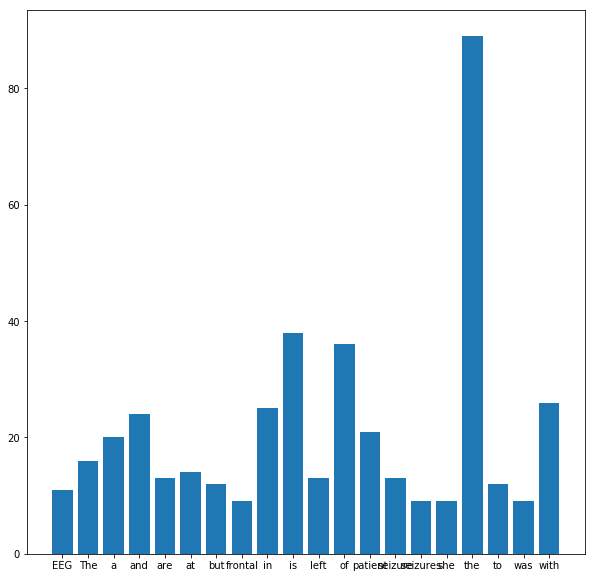

In [116]:
#fDist.most_common(30)
mostCommon = fDist.most_common(20)
xAxisVals = []
yAxisVals = []

plt.figure(figsize=(10,10))
for x in mostCommon:
    xAxisVals.append(x[0])
    yAxisVals.append(x[1])
plt.bar(xAxisVals,yAxisVals)
plt.show()

In [ ]:
'''
    splitFile = files.split("/")
    #print(splitFile)
    if len(splitFile)<6:
        pass
    else:
        patientId = splitFile[3]
        
        currentFile = splitFile[5]
        currentFileSplit = currentFile.split('_')
        sessionNumber = currentFileSplit[1]
        patientId = currentFileSplit[0]
        sessionId = str(patientId)+str(sessionNumber)
        #print("\t\t\t splitFile: ",currentFileSplit)
        #print("\t\tFilePath: "+files)
        currentFileExt = str(fileExt(currentFile))
        #print("\tCurrent File: "+currentFile) 
        if currentSession != sessionId: 
            currentSession = sessionId
            if bool(sessionEntry) == True:
                #Insert session into patient session list
                sessionEntry['edfList'] = edfList
                sessionEntry['lblList'] = lblList
                sessionEntry['tseList'] = tseList
                #print("CurrentSession: "+currentSession)
                
                if currentFileExt == ".txt":
                    sessionEntry['Report'] = currentFile
                    try:
                        with open(str(files),'r') as reportFile:
                            rText = reportFile.readlines()      
                        sessionEntry['ReportText'] = rText
                    except UnicodeDecodeError:
                        sessionEntry['ReportText'] = "Error Opening Report"
                elif currentFileExt  == ".edf":
                    edfList.append(currentFile)
                elif currentFileExt == ".lbl":
                    lblList.append(currentFile)
                elif currentFileExt == ".tse":
                    tseList.append(currentFile)
                    print("Adding Session!!!")
                    sessions.insert_one(sessionEntry)
                    sessionEntry = {}
            else:            #Found a new session
                print("Found an empty Session")
                print(sessionEntry)
                sessionEntry = {'sessionId':sessionId}
                sessionEntry['patientId'] = patientId
                lblList = []
                edfList = []
                tseList = []
                tseBiList = []
                lblBiList = []
                if currentFileExt == ".txt":
                    sessionEntry['Report'] = currentFile
                    try:
                        with open(str(files),'r') as reportFile:
                            rText = reportFile.readlines()      
                        sessionEntry['ReportText'] = rText
                    except UnicodeDecodeError:
                        sessionEntry['ReportText'] = "Error Opening Report"
                elif currentFileExt  == ".edf":
                    edfList.append(currentFile)
                elif currentFileExt == ".lbl":
                    lblList.append(currentFile)
                elif currentFileExt == ".tse":
                    tseList.append(currentFile)
            
        else:
            if currentFileExt == ".txt":
                sessionEntry['Report'] = currentFile
                try:
                    with open(str(files),'r') as reportFile:
                        rText = reportFile.readlines()      
                    sessionEntry['ReportText'] = rText
                except UnicodeDecodeError:
                    sessionEntry['ReportText'] = "Error Opening Report"
            elif currentFileExt  == ".edf":
                edfList.append(currentFile)
            elif currentFileExt == ".lbl":
                lblList.append(currentFile)
            elif currentFileExt == ".tse":
                tseList.append(currentFile)
                
            if patientId in patientList:
                #Add Session Id to patient sessions
                #Find patient entry, add session 
                continue
            else:
                #Add sessionId to patient session
                patients.insert_one({'patientId':patientId})
                patientList.append(patientId)
# break
            if sessionId in sessionList:
                continue
            else:
                sessionList.append(sessionId)
                if patientId in patientLi[=st:
                    sessions.update_one({"patientId":patientId},{'$push':{"sessionsId":sessionId}})
                else:
                    sessions.insert_one({{'patientId':patientId},{'sessionId':[sessionId]}})
            
        currentSession = sessionId
#print (patientList)
print (len(patientList))

'''